In [2]:
# read results
import pandas as pd
import math
genotype_odds = pd.read_csv('/home/hermuba/data0118/ontologies/genotype_fisher_odds_corrected.csv', index_col = 0)
df = genotype_odds.replace(0,0.0001).fillna(1).applymap(math.log10)

In [ ]:
# read CARD annotation, resfam
card = pd.read_csv('/home/hermuba/data0118/Escherichia0.70rm_plasmid_card.csv', index_col = 0) # loose card
resfam = pd.read_csv('/home/hermuba/data0118/resfam_anno.csv', index_col = 0)
resfam_abx = pd.read_csv('/home/hermuba/data0118/resfam_anno_abx.csv', index_col = 0)

# convert boolean (True False annotation) into one gene per color annotation
def bool_categorize(df):
    x = df.stack()
    return(pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)), index = x[x!=0].index.get_level_values(0)))

# CARD data

# extract resistance based on antibiotic types
abx_spec = card.loc[card.index.isin(genotype_odds.index),card.columns.str.contains('determinant')]

def replace_col_name(s):
    return(s.replace('determinant of ','').replace(' resistance', '').replace('resistance to', ''))
abx_spec.rename(columns = replace_col_name, inplace = True)

# select only the class of abx included
abx_spec = abx_spec.loc[:, ['beta-lactam','fluoroquinolone','aminoglycoside']]

# make it categorical
x = abx_spec.stack()
abx_series = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)), index = x[x!=0].index.get_level_values(0))


efflux_pump = card.loc[card.index.isin(genotype_odds.index), 'efflux pump complex or subunit conferring antibiotic resistance']

# all abx-related annotation are in card_annotation
card_annotation = pd.DataFrame(index = genotype_odds.index)
card_annotation.loc[efflux_pump.index, 'efflux pump'] = efflux_pump
card_annotation.loc[abx_series.index, 'antibiotic'] = abx_series

# make sidebar annotations
resfam_mechanism = bool_categorize(resfam.loc[resfam.index.isin(genotype_odds.index)])
resfam_abx = bool_categorize(resfam_abx.loc[resfam_abx.index.isin(genotype_odds.index)])
card_annotation.loc[resfam_mechanism.index, 'resfam_mechanism'] = resfam_mechanism
card_annotation.loc[resfam_abx.index,'resfam_abs'] = resfam_abx

In [47]:
card_annotation.to_csv('~/data0118/all_abx_anno.csv')

In [76]:
# color coding 
import numpy as np
import matplotlib.cm as cm

def make_lut(series, start = 2, rot = 0):
    '''
    input data series, return color mapping dictionary
    '''
    labels = series.dropna().unique()
    lut = dict(zip(set(labels), sns.cubehelix_palette(len(set(labels)), start = start, rot = rot))) # change l,s
    
    
    return(lut, series.map(lut))

def map_color_for_dataframe(df):
    
    no_cols = df.shape[1]
    
    # evenly distribute color around
    rots = [-1 + i* 3/no_cols for i in range(no_cols)]
    starts = [-1 + i* 3/no_cols for i in range(no_cols)]
    
    color_df = pd.DataFrame(columns = df.columns, index = df.index)
    luts = {}
    r = 0
    for col in df.columns:
        lut, color = make_lut(df[col], rot = rots[r], start = starts[r])
        color_df[col] = color
        luts[col] = lut
        r+=1
    return(color_df, lut)

In [77]:
cdf, luts = map_color_for_dataframe(card_annotation)

Text(448.04395604395603, 0.5, 'Gene Clusters')

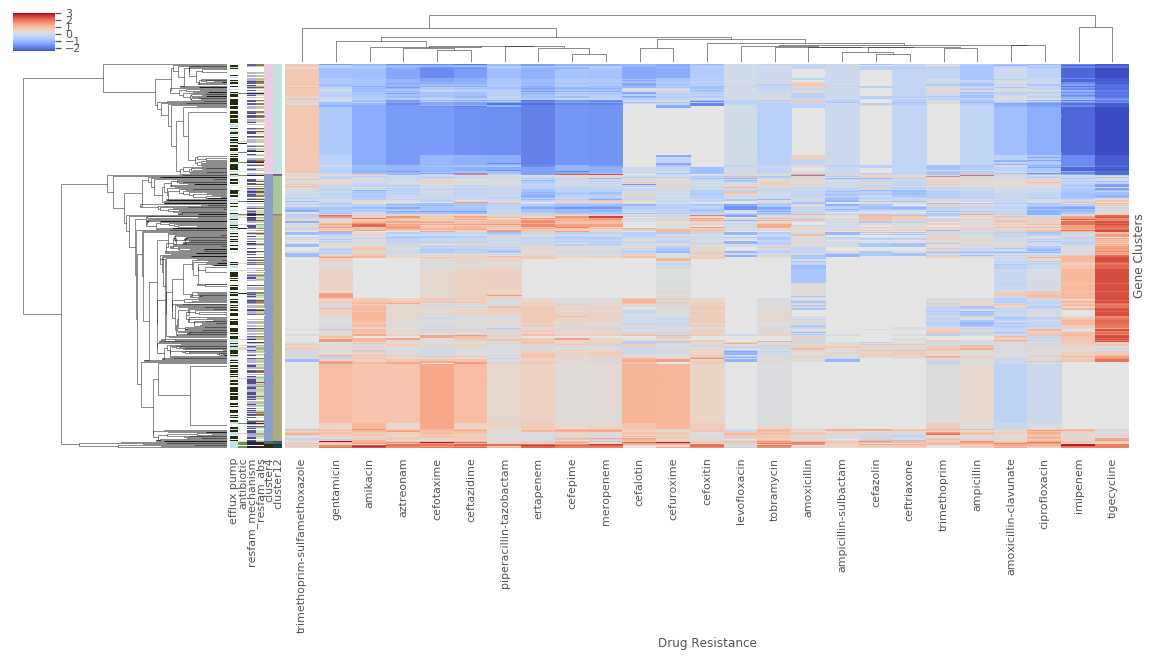

In [78]:
import seaborn as sns; sns.set(color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
mpl.style.use("ggplot")
# plot inline
%matplotlib inline
import matplotlib.patches as mpatches


g = sns.clustermap(df, row_colors=cdf, cmap = 'coolwarm', yticklabels = False ,mask = genotype_odds.isnull(), method = 'centroid', figsize = (20,8))

# ADDED: Remove labels.
ax = g.ax_heatmap
ax.set_xlabel("Drug Resistance")
ax.set_ylabel("Gene Clusters")




In [39]:
# return phenotype hierachial clustering
Z = g.dendrogram_row.linkage

# pick cluster
from scipy.cluster.hierarchy import inconsistent

depth = 5
incons = inconsistent(Z, depth)
incons[-10:] # avg, std, count, inconsistency for each of the last 10 merges of our hierarchical clustering with depth = 5

array([[ 2.9090054 ,  0.26689431,  8.        ,  1.43591009],
       [ 2.48068805,  0.77487439, 16.        ,  1.14531979],
       [ 2.72674608,  0.7522336 ,  3.        ,  0.98732232],
       [ 2.10057572,  1.08184803,  4.        ,  1.36142773],
       [ 2.69842813,  0.79838769, 12.        ,  1.29705423],
       [ 3.21749538,  0.46557359,  8.        ,  1.5312545 ],
       [ 2.131061  ,  0.68942171, 11.        ,  2.80737361],
       [ 2.6767017 ,  1.23168917,  8.        ,  1.74911885],
       [ 3.13851777,  1.19960176, 14.        ,  1.90042001],
       [ 3.23513157,  1.38096232, 18.        ,  2.48287059]])

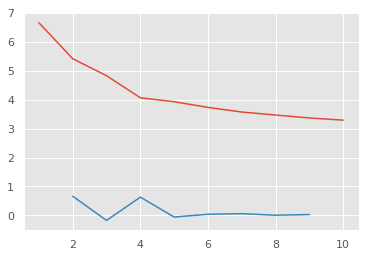

clusters: 2


In [40]:
# choose optimal depth
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

In [45]:
from scipy.cluster.hierarchy import fcluster
cluster = fcluster(Z, 12, criterion='maxclust') # but 9 doesn't show the one I am interested in
cluster = pd.Series(cluster, index = genotype_odds.index)


In [46]:
card_annotation['cluster12'] = cluster

In [100]:
cluster.to_csv('/home/hermuba/data0118/ontologies/phenotype_cluster_25drug.csv')

/home/hermuba/miniconda3/envs/ddot/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [79]:
g = sns.clustermap(df, cmap = 'coolwarm', row_colors=cluster_color, yticklabels = False)

# set legend

import matplotlib.patches as mpatches
legend_TN = [mpatches.Patch(color=lut5[c],label=c) for c in lut5.keys()]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
l2.set_title(title='phenotype cluster',prop={'size':10})

NameError: name 'cluster_color' is not defined

In [55]:
drug_df = pd.read_pickle('/home/hermuba/data0118/drug_category')

In [81]:
drug_df.loc[drug_df['drug']== 'tigecycline'] # wrong

,category,drug,order
88,b_lactam_inhibitor,tigecycline,1.0


In [92]:
drug_df.loc[drug_df['drug']== 'amoxicillin']

,category,drug,order
80,aminoglycosides,amoxicillin,8.0


In [95]:
#drug_df.iloc[88]= ['b_lactam_inhibitor', 'amoxicillin', 1.0]

In [96]:
#drug_df.iloc[80]= ['aminoglycosides', 'tigecycline', 8.0]

In [99]:
#drug_df.to_pickle('/home/hermuba/data0118/drug_category')

In [59]:
drug_order = drug_df.loc[drug_df['drug'].isin(genotype_odds.columns)].sort_values(by = 'order')['drug']

In [78]:
df.loc[r2.sort_values().index, drug_order].columns


Index(['ampicillin', 'tigecycline', 'piperacillin-tazobactam', 'ceftazidime',
       'cefoxitin', 'ceftriaxone', 'cefotaxime', 'cefepime', 'cefazolin',
       'cefuroxime', 'aztreonam', 'meropenem', 'imipenem', 'ertapenem',
       'amoxicillin', 'tobramycin', 'gentamicin', 'amikacin', 'levofloxacin',
       'ciprofloxacin', 'trimethoprim'],
      dtype='object')

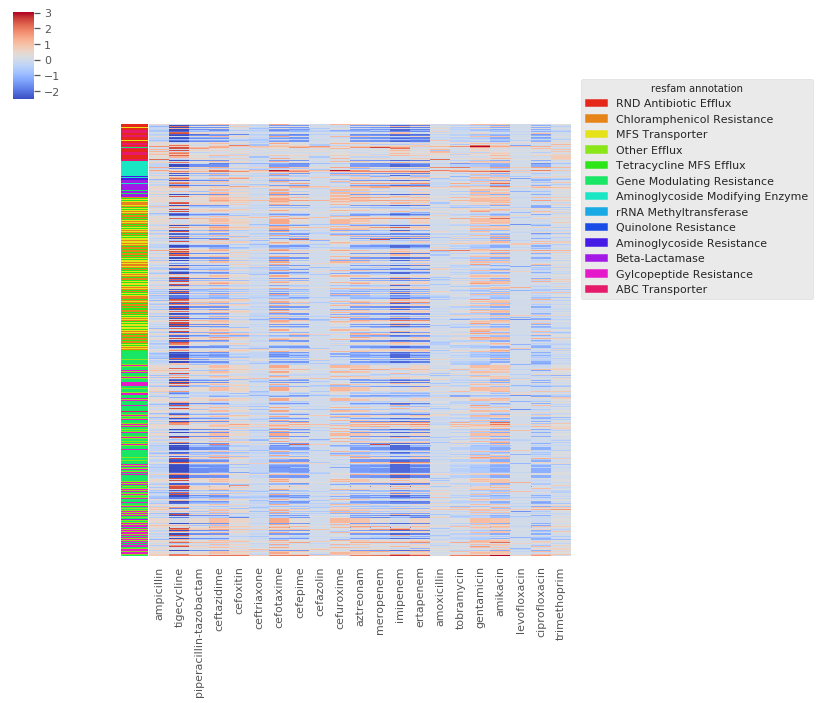

In [91]:
g = sns.clustermap(df.loc[r2.sort_values().index, drug_order], row_cluster = False, col_cluster = False, row_colors=r2_color, cmap = 'coolwarm', yticklabels = False)
legend_TN = [mpatches.Patch(color=lut4[c],label=c) for c in lut4.keys()]
l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)
l2.set_title(title='resfam annotation',prop={'size':10}) # some have 2 classes